# Air Voids

In [1]:
#%% IMPORTS
#BASICS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import absolute
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline
from IPython.display import display, Markdown, Latex
pd.options.display.max_columns = None

#STATISTICS
from scipy.stats import normaltest
from scipy import stats

#ML TRAINING AND DATA PREPROCESSING
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures

#ML MODELS
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance

#MODEL EVALUATION
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

#METRICS
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## 1. Methods

In [2]:
#Eliminate Outliers based on the interquantile
#datFrame: Data frame where the outliers will be eliminated.
#columnName: the name of the column where the outliers will be identified.
def eliminateOutliers (dataFrame, columnName):
    Q1 = dataFrame[columnName].quantile(0.25)
    Q3 = dataFrame[columnName].quantile(0.75)
    IQR = Q3 - Q1
    print('Initial dataframe size: '+str(dataFrame.shape))
    dataFrame = dataFrame[(dataFrame[columnName] < (Q3 + 1.5 * IQR)) & (dataFrame[columnName] > (Q1 - 1.5 * IQR))]
    print('Final dataframe size: '+str(dataFrame.shape))
    return dataFrame

In [3]:
# Create the boxplot graphs for the categorical variables
# dataFrame: Data frame associated to the property of interest (dfAirVoids, dfMS, dfMF, dfITS, dfTSR)
# propertyOfInterest: the name of the column where the property of interest is located.
# columnName1...4: The categorical columns to evaluate.
def displayBoxPlotGraphs (dataFrame, propertyOfInterest, columnName1, columnName2, columnName3, columnName4):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
    sns.boxplot(y = propertyOfInterest, x = columnName1, data=dataFrame,  orient='v' , ax=ax1)
    sns.boxplot(y = propertyOfInterest, x = columnName2, data=dataFrame,  orient='v' , ax=ax2)
    sns.boxplot(y = propertyOfInterest, x= columnName3, data=dataFrame,  orient='v' , ax=ax3)
    sns.boxplot(y= propertyOfInterest, x= columnName4, data=dataFrame,  orient='v' , ax=ax4)

In [4]:
#Method that print the best parameters, R2 and MSE based on a grid search.
def printBestModel (grid):
    mse = -grid.best_score_
    print('Best Parameters:' , grid.best_params_)
    print('Best MSE:' + str(mse))

##  2. Data Import 

In [5]:
#%%DATA READING AND INITIAL PREPROCESSING
numericColumns = ['Aggregate absorption (%)',
                  'Apparent specific gravity',
                    0.075,
                    0.3,
                    0.6,
                    2.36,
                    4.75,
                    9.5,
                    12.5,
                    19,
                    'Plastic particle size (mm)',
                    'Mixing speed (RPM)',
                    'Mixing Temperature',
                    'Mixing Time (hours)',
                    'Plastic Addition by bitumen weight (%)',
                    'Bitumen content in the sample'
                    ]
categoricalColumns = ['Modified asphalt Mix?',
                      'Agreggate Type',
                    'Aggregate absorption [%]',
                    'Filler used',
                    'Consolidated bitumen penetration grade',
                    'New Plastic Type',
                    'Plastic pretreatment',
                    'Plastic shape',
                    'Plastic Size',
                    'Mixing Process',
                    'Aggregates replacement ?',
                    'Bitumen replacement?',
                    'Filler replacement',
                    'Property',
                    'Units']
#It returns the dataframe of interes based on the property - 'AirVoids', 'MS', 'MF', 'ITS', 'TSR'
def returnDf (propertyOfInterest):
    df = pd.read_excel('fileML.xlsx', sheet_name = propertyOfInterest, engine='openpyxl')
    df = df.set_index(propertyOfInterest + ' ID')
    df.loc[:,:'Units'] = df.loc[:,:'Units'].applymap(str)
    df.loc[:,:'Units'] = df.loc[:,:'Units'] .applymap(str.strip)
    df.replace('NS', np.nan, inplace = True)
    df[numericColumns] = df[numericColumns].replace('N/a', 0).astype(float)
    df.columns = df.columns.astype(str)
    return df

In [6]:
dfAirVoids = returnDf('AirVoids')

## 3. Data Exploration
###  3.1 Total Sample

In [7]:
dfAirVoids = eliminateOutliers(dfAirVoids, 'Air voids of the sample (%)')

Initial dataframe size: (305, 34)
Final dataframe size: (288, 34)


In [9]:
dfAirVoids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 1 to 305
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Article ID                              288 non-null    object 
 1   Global ID                               288 non-null    object 
 2   Modified asphalt Mix?                   288 non-null    object 
 3   Agreggate Type                          197 non-null    object 
 4   Aggregate absorption (%)                231 non-null    float64
 5   Apparent specific gravity               77 non-null     float64
 6   0.075                                   254 non-null    float64
 7   0.3                                     254 non-null    float64
 8   0.6                                     251 non-null    float64
 9   2.36                                    258 non-null    float64
 10  4.75                                    258 non-null    float6

In [9]:
columnsOfInteres = numericColumns[0:2]+numericColumns[10:]+['Air voids of the sample (%)']

In [10]:
dfAirVoids.describe(include = 'all')

Article ID Global ID Modified asphalt Mix? Agreggate Type  \
count         288       288                   288            197   
unique         28       288                     2              7   
top            19       911                   Yes        Granite   
freq           70         1                   228             97   
mean          NaN       NaN                   NaN            NaN   
std           NaN       NaN                   NaN            NaN   
min           NaN       NaN                   NaN            NaN   
25%           NaN       NaN                   NaN            NaN   
50%           NaN       NaN                   NaN            NaN   
75%           NaN       NaN                   NaN            NaN   
max           NaN       NaN                   NaN            NaN   

        Aggregate absorption (%)  Apparent specific gravity       0.075  \
count                 231.000000                  77.000000  254.000000   
unique                       NaN                        NaN         NaN   
top                          NaN                        NaN         NaN   
freq                         NaN                        NaN         NaN   
mean                    1.090281                   2.705195    5.450787   
std                     0.888070                   0.066564    1.376229   
min                     0.130000                   2.590000    2.190000   
25%                     0.470000                   2.650000    4.620000   
50%                     0.990000                   2.710000    5.280000   
75%                     1.200000                   2.740000    5.980000   
max                     3.040000                   2.800000   10.300000   

               0.3         0.6        2.36        4.75         9.5  \
count   254.000000  251.000000  258.000000  258.000000  251.000000   
unique         NaN         NaN         NaN         NaN         NaN   
top            NaN         NaN         NaN         NaN         NaN   
freq           NaN         NaN         NaN         NaN         NaN   
mean     13.033189   19.983665   35.683721   47.867287   66.346653   
std       3.533186    6.327548    7.182231    9.232061   10.580957   
min       5.300000   10.070000   20.000000   24.000000   47.000000   
25%      10.150000   14.770000   29.850000   41.540000   59.850000   
50%      12.500000   19.780000   35.370000   46.150000   60.510000   
75%      14.470000   21.250000   38.800000   51.240000   70.610000   
max      24.500000   39.160000   54.100000   71.080000   96.870000   

              12.5          19      Filler used  \
count   243.000000  258.000000              122   
unique         NaN         NaN                4   
top            NaN         NaN  Portland Cement   
freq           NaN         NaN               49   
mean     77.845597   91.334884              NaN   
std      11.333933    7.402693              NaN   
min      66.630000   83.110000              NaN   
25%      69.380000   84.460000              NaN   
50%      69.380000   90.610000              NaN   
75%      87.740000  100.000000              NaN   
max     100.000000  100.020000              NaN   

       Bitumen Type Penetration Grade Consolidated bitumen penetration grade  \
count                             288                                    288   
unique                              6                                      3   
top                             50/70                                  50/70   
freq                              113                                    201   
mean                              NaN                                    NaN   
std                               NaN                                    NaN   
min                               NaN                                    NaN   
25%                               NaN                                    NaN   
50%                               NaN                                    NaN   
75%                               N

In total, there is $\color{red}{\text{288}}$ observations. Let's see if there is any correlation with the continual and categorical variables. The mean of $\color{red}{\text{Air voids}}$, which is the common value for the optimum asphalt mix design.

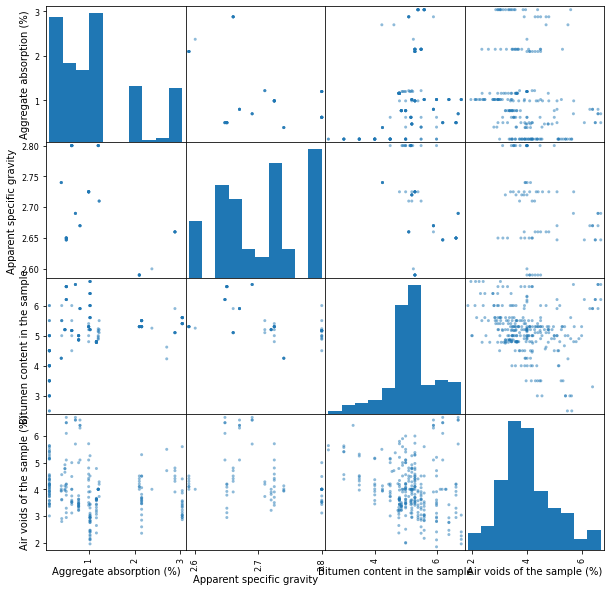

In [83]:
scatter_matrix(dfAirVoids[['Aggregate absorption (%)', 'Apparent specific gravity', 'Bitumen content in the sample', 'Air voids of the sample (%)']], figsize=(10, 10))
plt.show()

It is possible to see a negative correlation between $\color{red}{\text{Bitumen Content}}$  and $\color{red}{\text{Air Voids}}$. This makes sense because higher bitumen quantities will fill more voids in the mixture.

Among the categorical variables, we will initially focus on the general ones that might have an effect on air voids: $\color{red}{\text{Aggregate type}}$, $\color{red}{\text{Filler used}}$ and $\color{red}{\text{Bitumen Grade}}$

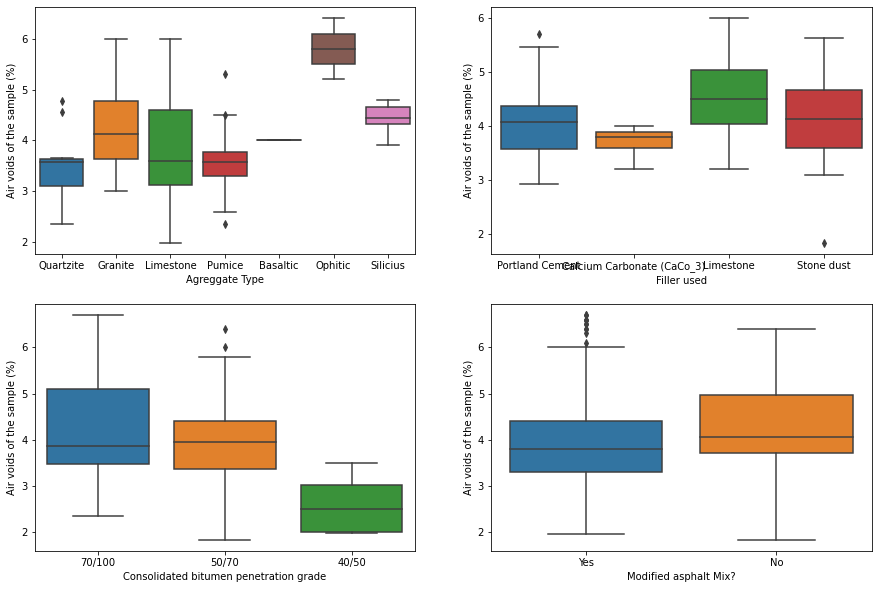

In [85]:
displayBoxPlotGraphs(dataFrame = dfAirVoids, propertyOfInterest = "Air voids of the sample (%)", columnName1 = "Agreggate Type", columnName2 = "Filler used", columnName3 = "Consolidated bitumen penetration grade", columnName4 = "Modified asphalt Mix?")

Within the  $\color{red}{\text{Aggregate type}}$, although it exists differences -especially with the Ophitic- this data migh not be robust enough due to the sample size of this type of aggregate. It happens the same with the  $\color{red}{\text{Bitumen type}}$, where only  $\color{purple}{\text{5}}$ observations used the 40/50 bitumen. The  $\color{red}{\text{addition of plastic}}$ seems to have not strong influence in the air voids.

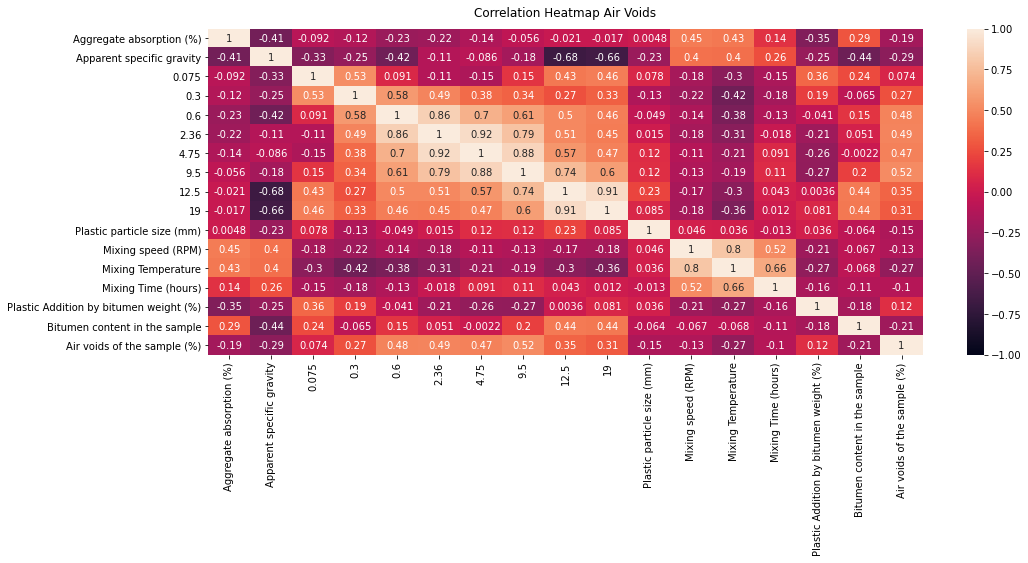

In [88]:
#CORRELATION:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfAirVoids.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap Air Voids', fontdict={'fontsize':12}, pad=12);

###  3.2 Modified mixtures

In [91]:
dfAirVoidsModvsUnmod = dfAirVoids [['Modified asphalt Mix?', 'Air voids of the sample (%)']]
dfAirVoidsModvsUnmod.groupby(['Modified asphalt Mix?'], as_index=False).describe()

Air voids of the sample (%)                                                  \
                        count      mean       std   min     25%   50%     75%   
0                        60.0  4.250667  0.838416  1.84  3.7125  4.05  4.9775   
1                       228.0  3.945439  1.017312  1.95  3.3000  3.80  4.4025   

        
   max  
0  6.4  
1  6.7

In [93]:
dfAirVoidsModified = dfAirVoids[dfAirVoids['Modified asphalt Mix?']=='Yes']
dfAirVoidsModified.describe(include = "all")

Article ID Global ID Modified asphalt Mix? Agreggate Type  \
count         228       228                   228            162   
unique         25       228                     1              7   
top            19       269                   Yes        Granite   
freq           62         1                   228             81   
mean          NaN       NaN                   NaN            NaN   
std           NaN       NaN                   NaN            NaN   
min           NaN       NaN                   NaN            NaN   
25%           NaN       NaN                   NaN            NaN   
50%           NaN       NaN                   NaN            NaN   
75%           NaN       NaN                   NaN            NaN   
max           NaN       NaN                   NaN            NaN   

        Aggregate absorption (%)  Apparent specific gravity       0.075  \
count                 184.000000                  56.000000  201.000000   
unique                       NaN                        NaN         NaN   
top                          NaN                        NaN         NaN   
freq                         NaN                        NaN         NaN   
mean                    1.107011                   2.699964    5.498607   
std                     0.900510                   0.066549    1.347934   
min                     0.130000                   2.590000    2.190000   
25%                     0.470000                   2.650000    4.620000   
50%                     0.990000                   2.690000    5.280000   
75%                     1.200000                   2.740000    5.980000   
max                     3.040000                   2.800000   10.300000   

               0.3         0.6        2.36        4.75         9.5  \
count   201.000000  198.000000  204.000000  204.000000  198.000000   
unique         NaN         NaN         NaN         NaN         NaN   
top            NaN         NaN         NaN         NaN         NaN   
freq           NaN         NaN         NaN         NaN         NaN   
mean     13.097910   19.899646   35.367647   47.635294   66.047929   
std       3.518913    6.361360    7.213825    9.377532   10.582683   
min       5.300000   10.070000   20.000000   24.000000   47.000000   
25%      10.150000   14.770000   29.850000   41.540000   59.850000   
50%      12.970000   19.780000   35.370000   46.150000   60.510000   
75%      14.470000   21.137500   36.895000   51.350000   70.480000   
max      24.500000   39.160000   54.100000   71.080000   96.870000   

              12.5          19      Filler used  \
count   195.000000  204.000000               93   
unique         NaN         NaN                4   
top            NaN         NaN  Portland Cement   
freq           NaN         NaN               38   
mean     77.605846   90.962892              NaN   
std      11.553937    7.531754              NaN   
min      66.630000   83.110000              NaN   
25%      69.380000   84.460000              NaN   
50%      69.380000   84.460000              NaN   
75%      87.740000  100.000000              NaN   
max     100.000000  100.020000              NaN   

       Bitumen Type Penetration Grade Consolidated bitumen penetration grade  \
count                             228                                    228   
unique                              6                                      3   
top                             50/70                                  50/70   
freq                               90                                    157   
mean                              NaN                                    NaN   
std                               NaN                                    NaN   
min                               NaN                                    NaN   
25%                               NaN                                    NaN   
50%                               NaN                                    NaN   
75%                               N

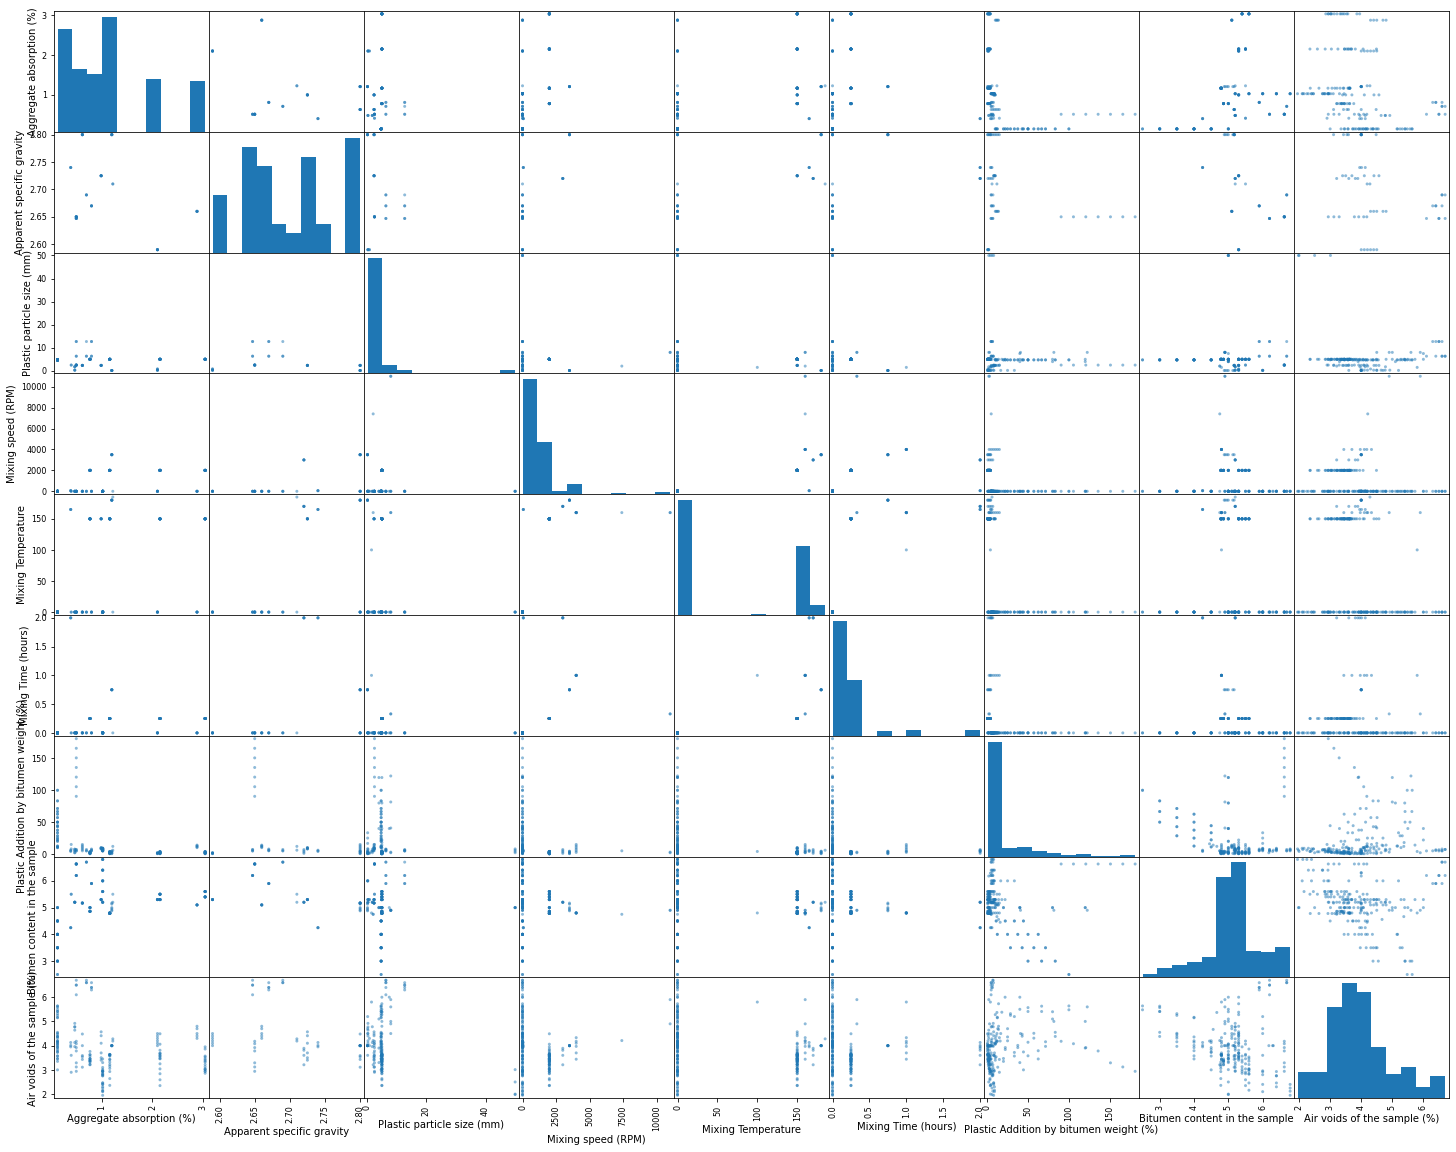

In [96]:
scatter_matrix(dfAirVoidsModified[columnsOfInteres], figsize=(25, 20))
plt.show()

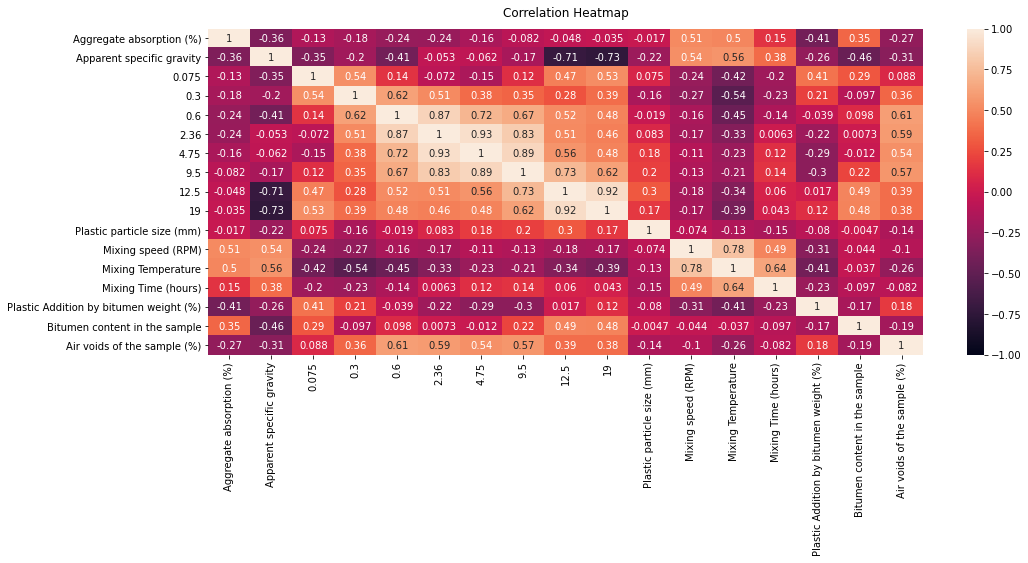

In [99]:
#CORRELATION:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfAirVoidsModified.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

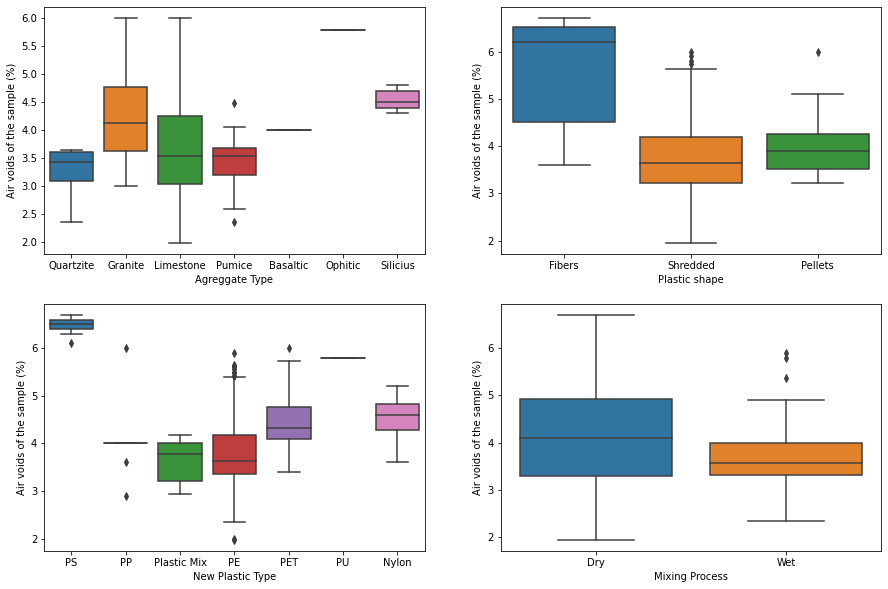

In [101]:
displayBoxPlotGraphs(dataFrame = dfAirVoidsModified, propertyOfInterest = "Air voids of the sample (%)", columnName1 = "Agreggate Type", columnName2 = "Plastic shape", columnName3 = "New Plastic Type", columnName4 = "Mixing Process")

Not much difference among dry and wet

###  3.3 Wet vs. Dry Mixing

In [102]:
dfAirVoidsWetvsDry = dfAirVoidsModified [['Mixing Process', 'Air voids of the sample (%)']]
dfAirVoidsWetvsDry.groupby(['Mixing Process'], as_index=False).describe()

Air voids of the sample (%)                                               \
                        count      mean       std   min   25%   50%    75%   
0                       133.0  4.162256  1.185640  1.95  3.30  4.10  4.920   
1                        95.0  3.641895  0.604626  2.35  3.32  3.57  3.985   

        
   max  
0  6.7  
1  5.9

C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


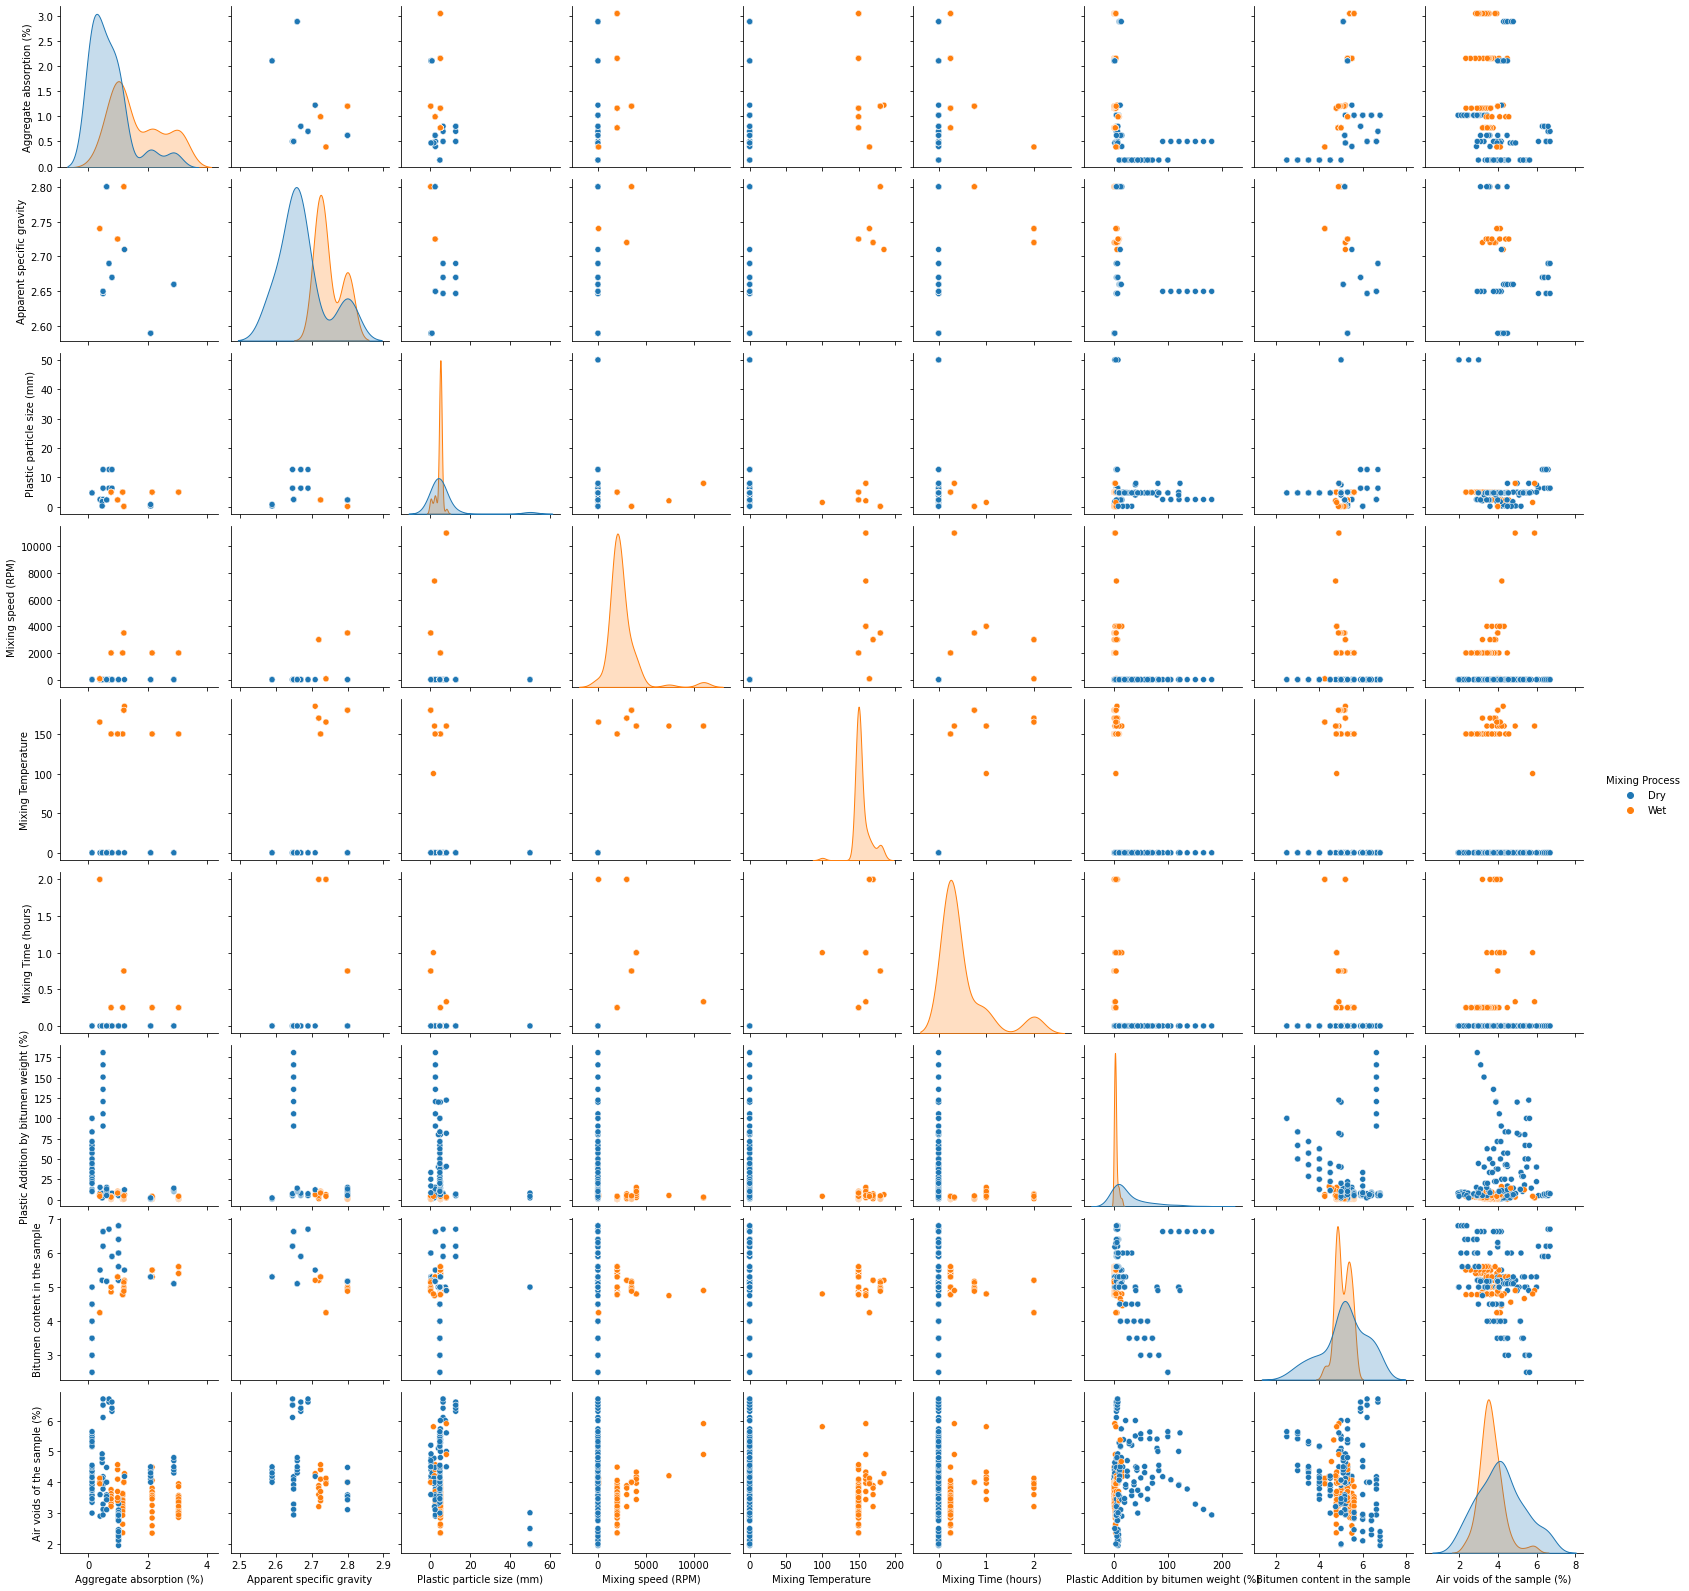

In [55]:
sns.pairplot(dfAirVoidsModified[columnsOfInteres+['Mixing Process']], hue="Mixing Process", height=2.5)

##  **Air Voids summary:**

*   There are missing values mainly in $\color{red}{\text{Apparent specific gravity}}$, $\color{red}{\text{Aggregate type}}$ and $\color{red}{\text{filler used}}$.
*   Total sample: # observations = 288, Mean = 4, Standard deviation = 0.98 
*   Sample with asphalt modified: # observations = 228, Mean = 3.94, Standard deviation = 1.017
*   It seems that there will be a strong correlation with $\color{red}{\text{Aggregates gradation}}$.
*   Dry vs. Wet:
    *   Not strong difference between dry and wet.
    *   Mean in wet = 3.64, Mean in dry = 4.16.


## 4. Data Pre-processing

In [8]:
dfAirVoids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 1 to 305
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Article ID                              288 non-null    object 
 1   Global ID                               288 non-null    object 
 2   Modified asphalt Mix?                   288 non-null    object 
 3   Agreggate Type                          197 non-null    object 
 4   Aggregate absorption (%)                231 non-null    float64
 5   Apparent specific gravity               77 non-null     float64
 6   0.075                                   254 non-null    float64
 7   0.3                                     254 non-null    float64
 8   0.6                                     251 non-null    float64
 9   2.36                                    258 non-null    float64
 10  4.75                                    258 non-null    float6

*   Process for dealing with missing categorical values:

    1.  I will eliminate the rows with Nan values in the column $\color{red}{\text{New Plastic Type}}$. In total, there is 24 missing values, which represent 8.33% of the sample
    2.  Replace the 'N/a' value when there is no modifiation of the asphalt mix.

*   Process for dealing with missing numeric values:

    *   The imputer used was the multivariable imputer, and the estimator was the ExtraTreeRegressor ([link][1]).
    By using this estimator, I did not get any negative values among the missing features, and it presents a low MSE value.
    
[1]:https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py  

In [9]:
#Categorical Variables
dfAirVoidsCleaned = dfAirVoids.drop(['Article ID', 
                                    'Global ID',
                                    'Modified asphalt Mix?',
                                    'Agreggate Type', 
                                    'Apparent specific gravity', 
                                    'Filler used', 
                                    'Bitumen Type Penetration Grade', 
                                    'Property', 
                                    'Units', 
                                    'Plastic Size' ], axis = 1)
dfAirVoidsCleaned = dfAirVoidsCleaned.replace('N/a', 0)
dfAirVoidsCleaned = dfAirVoidsCleaned.dropna(subset=['New Plastic Type'])
dfAirVoidsCleaned = pd.get_dummies(dfAirVoidsCleaned, columns=['New Plastic Type'], drop_first=False)
dfAirVoidsCleaned = pd.get_dummies(dfAirVoidsCleaned, drop_first=True)
dfAirVoidsCleaned = dfAirVoidsCleaned.drop(['New Plastic Type_0'], axis = 1)

In [10]:
#IMPUTATION OF MISSING VALUES
imputer = IterativeImputer (estimator = ExtraTreesRegressor(n_estimators=10, random_state = 123), max_iter=50,random_state = 123)
n = imputer.fit_transform(dfAirVoidsCleaned)
dfAirVoidsCleanedImputed = pd.DataFrame(n, columns = list(dfAirVoidsCleaned.columns))
print ('There is '+str(sum(n < 0 for n in dfAirVoidsCleanedImputed.values.flatten()))+' negative values in the new Dataframe')

There is 0 negative values in the new Dataframe


In [11]:
dfAirVoidsCleanedImputed['New Plastic Type_Nylon'] = dfAirVoidsCleanedImputed['New Plastic Type_Nylon'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed['New Plastic Type_PE'] = dfAirVoidsCleanedImputed['New Plastic Type_PE'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed['New Plastic Type_PET'] = dfAirVoidsCleanedImputed['New Plastic Type_PET'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed['New Plastic Type_PP'] = dfAirVoidsCleanedImputed['New Plastic Type_PP'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed['New Plastic Type_PS'] = dfAirVoidsCleanedImputed['New Plastic Type_PS'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed['New Plastic Type_PU'] = dfAirVoidsCleanedImputed['New Plastic Type_PU'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed['New Plastic Type_Plastic Mix'] = dfAirVoidsCleanedImputed['New Plastic Type_Plastic Mix'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed = dfAirVoidsCleanedImputed.drop(['Plastic Addition by bitumen weight (%)'], axis = 1)

In [12]:
 #Feature Scaling
 scaler = MinMaxScaler()
 dfAirVoidsCleanedImputedScaled = pd.DataFrame(scaler.fit_transform(dfAirVoidsCleanedImputed), columns = list(dfAirVoidsCleanedImputed.columns))
 dfAirVoidsCleanedImputedScaled.to_clipboard()

In [13]:
dfAirVoidsCleanedImputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 33 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Aggregate absorption (%)                       264 non-null    float64
 1   0.075                                          264 non-null    float64
 2   0.3                                            264 non-null    float64
 3   0.6                                            264 non-null    float64
 4   2.36                                           264 non-null    float64
 5   4.75                                           264 non-null    float64
 6   9.5                                            264 non-null    float64
 7   12.5                                           264 non-null    float64
 8   19                                             264 non-null    float64
 9   Plastic particle size (mm)                     264 non

## 5. Model Training

In [14]:
X = dfAirVoidsCleanedImputedScaled.loc[:, dfAirVoidsCleanedImputedScaled.columns != 'Air voids of the sample (%)']
y = dfAirVoidsCleanedImputedScaled.loc[:,'Air voids of the sample (%)']
cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = 123)

### 5.1 Model Evaluation
#### Linear Model

In [ ]:
param_grid = {'fit_intercept': [True, False],
            'positive': [True, False]}
grid = GridSearchCV(LinearRegression(), param_grid, cv = cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

#### Lasso Linear Model


In [24]:
param_grid = {'alpha': [0.001,1, 10, 15, 30, 50, 100],
            'fit_intercept':[True, False],
            'positive': [True, False]}
grid = GridSearchCV(Lasso(), param_grid, cv=cv, scoring=['neg_mean_squared_error'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007020751562347272, tolerance: 0.006129253247303085
  model = cd_fast.enet_coordinate_descent(
Best Parameters: {'alpha': 0.001, 'fit_intercept': True, 'positive': False}
Best MSE:0.016808604316501344


#### Ridge linear regression model

In [25]:
param_grid = {'alpha': [7, 8, 10,100],
'fit_intercept': [True, False],
'solver': [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid = GridSearchCV(Ridge(), param_grid, cv=cv, scoring=['neg_mean_squared_error'], refit = 'neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'alpha': 7, 'fit_intercept': True, 'solver': 'lsqr'}
Best MSE:0.01976065700058514


#### Linear Elastic Net

In [26]:
param_grid = {'alpha': [0.01,1,2,3,4],
'fit_intercept': [True, False]}
grid = GridSearchCV(ElasticNet(), param_grid, cv=cv, scoring=['neg_mean_squared_error'], refit = 'neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'alpha': 0.01, 'fit_intercept': False}
Best MSE:0.02266188292807017


#### Polynomial Model

In [27]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'linearregression__fit_intercept': [True, False],
'linearregression__positive':[True, False]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error'], refit = 'neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'linearregression__fit_intercept': False, 'linearregression__positive': True, 'polynomialfeatures__degree': 3}
Best MSE:0.019864507601140956


#### Lasso Polynomial Model

In [28]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Lasso(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
            'lasso__alpha': [1,2, 3, 10, 15, 30],
            'lasso__fit_intercept':[True, False],
            'lasso__positive': [True, False],
            'lasso__max_iter': [2000,3000, 3500]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'lasso__alpha': 1, 'lasso__fit_intercept': True, 'lasso__max_iter': 2000, 'lasso__positive': True, 'polynomialfeatures__degree': 2}
Best MSE:0.037236626681753225


#### Ridge polynomial regression

In [29]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'ridge__alpha':[20,30,50, 60],
'ridge__fit_intercept': [True, False],
'ridge__solver': [ 'lsqr', 'cholesky', 'sparse_cg', 'auto']}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'polynomialfeatures__degree': 3, 'ridge__alpha': 20, 'ridge__fit_intercept': True, 'ridge__solver': 'sparse_cg'}
Best MSE:0.014735085472025565


#### Support vector regression

In [30]:
param_grid = {
    'kernel':['linear','rbf', 'sigmoid', 'poly'],
    'degree':[2,3,4],
    'C':[0.01,1,5,10],
    'epsilon':[0.1,0.2, 1, 1.5]
}
grid = GridSearchCV(SVR(), param_grid, cv=cv, scoring=['neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'C': 5, 'degree': 2, 'epsilon': 0.1, 'kernel': 'rbf'}
Best MSE:0.01374299774036023


#### Decision tree regressor

In [31]:
param_grid = {
    'max_depth':[1,2,3,5,10,30],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[0.4,1,2]
}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=cv, scoring=['neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best MSE:0.011186917099464304


#### Random Forest


In [19]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
grid = RandomizedSearchCV(RandomForestRegressor(), 
                        random_grid, 
                        cv=cv, 
                        scoring=['neg_mean_squared_error'], 
                        refit='neg_mean_squared_error', 
                        n_iter=10,
                        )
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': True}
Best MSE:0.010111280561082141


#### Extra tree regressor

In [21]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(ExtraTreesRegressor(), param_grid, cv=cv, scoring=['neg_mean_squared_error'], refit='neg_mean_squared_error', n_iter=10, verbose= 3)
grid.fit(X, y)
printBestModel(grid)

ators=1000; neg_mean_squared_error: (test=-0.016) total time=   1.4s
[CV 42/75] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; neg_mean_squared_error: (test=-0.022) total time=   1.3s
[CV 43/75] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; neg_mean_squared_error: (test=-0.016) total time=   1.2s
[CV 44/75] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; neg_mean_squared_error: (test=-0.015) total time=   1.2s
[CV 45/75] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; neg_mean_squared_error: (test=-0.017) total time=   1.4s
[CV 46/75] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; neg_mean_squared_error: (test=-0.014) total time=   1.3s
[CV 47/75] END bootst

#### XG Boost Regressor

In [22]:
XGBoostModel = XGBRegressor(random_state=123)
scores = cross_val_score(XGBoostModel, X, y , scoring = 'neg_mean_squared_error', cv = cv)
scores = np.absolute(scores)
print (scores.mean())

0.008752142398227147


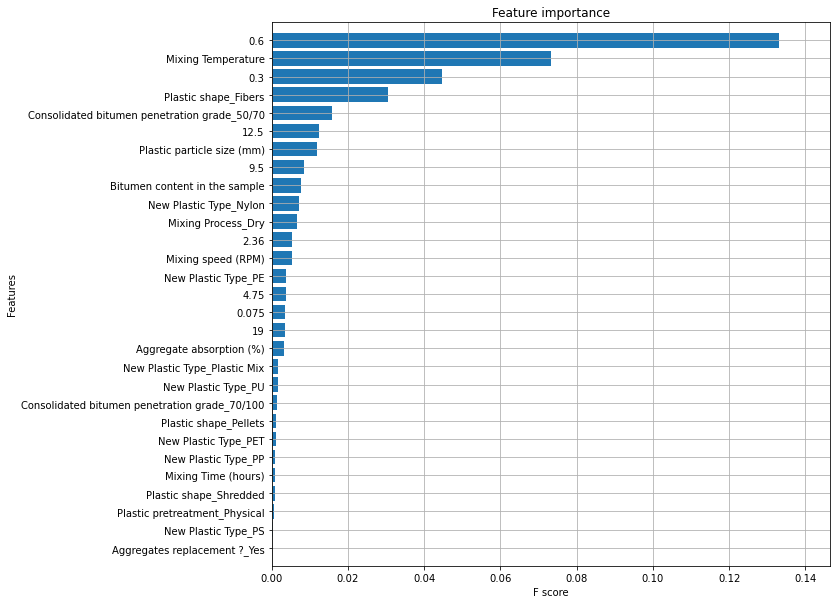

In [16]:
#Graph employed for selecting important features during tunning
XGBoostModel.fit(X,y)
ax = plot_importance(XGBoostModel, height=0.8, importance_type='gain', show_values=False)
fig = ax.figure
fig.set_size_inches(10,10)


*The Gain is the most relevant attribute to interpret the relative importance of each feature.* [Reference](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7)

## 6. Best Model Tunning

In [17]:
X.columns = X.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
cv = RepeatedKFold(n_splits = 5, n_repeats = 15, random_state = 123)

### 6.1. Feature selection

In [18]:
features_MSE = {}
def addMSE (columns, string):
    cv_results = cross_validate(XGBRegressor(random_state = 1), X_train[columns], y_train, cv = cv, scoring = ['neg_mean_squared_error'])
    MSE = np.average(-cv_results['test_neg_mean_squared_error'])
    features_MSE[string] = MSE

In [177]:
X_train.columns

Index(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'New Plastic Type_Nylon',
       'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PS', 'New Plastic Type_PU',
       'New Plastic Type_Plastic Mix',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'],
      dtype='object')

In [178]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19'], 'Gradation')

In [179]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
       'Mixing Temperature'], 
       'Gradation \n Mixing temperature')

In [180]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
       'Mixing Temperature',
       'Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded'], 
       'Gradation \n Mixing temperature \n Plastic shape')

In [181]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
       'Mixing Temperature',
       'Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
       'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100'], 
       'Gradation \n Mixing temperature \n Plastic shape \n Bitumen type')

In [182]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
       'Mixing Temperature',
       'Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
       'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100',
       'Plastic particle size (mm)'], 
       'Gradation \n Mixing temperature \n Plastic shape \n Bitumen type \n Plastic size')

In [183]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
       'Mixing Temperature',
       'Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
       'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100',
       'Plastic particle size (mm)',
       'Bitumen content in the sample'], 
       'Gradation \n Mixing temperature \n Plastic shape \n Bitumen type \n Plastic size \n Bitumen content')

In [184]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
       'Mixing Temperature',
       'Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
       'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100',
       'Plastic particle size (mm)',
       'Bitumen content in the sample',
       'New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PS', 'New Plastic Type_PU','New Plastic Type_Plastic Mix'], 
       'Gradation \n Mixing temperature \n Plastic shape \n Bitumen type \n Plastic size \n Bitumen content \n Plastic Type')

In [185]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
       'Mixing Temperature',
       'Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
       'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100',
       'Plastic particle size (mm)',
       'Bitumen content in the sample',
       'New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PS', 'New Plastic Type_PU','New Plastic Type_Plastic Mix',
       'Mixing Process_Dry', 'Mixing Process_Wet'], 
       'Gradation \n Mixing temperature \n Plastic shape \n Bitumen type \n Plastic size \n Bitumen content \n Plastic Type \n Mixing Process')

In [186]:
addMSE(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'New Plastic Type_Nylon',
       'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PS', 'New Plastic Type_PU',
       'New Plastic Type_Plastic Mix',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'], 
       'Gradation \n Mixing temperature \n Plastic shape \n Bitumen type \n Plastic size \n Bitumen content \n Plastic Type \n Mixing Process \n Rest of features')

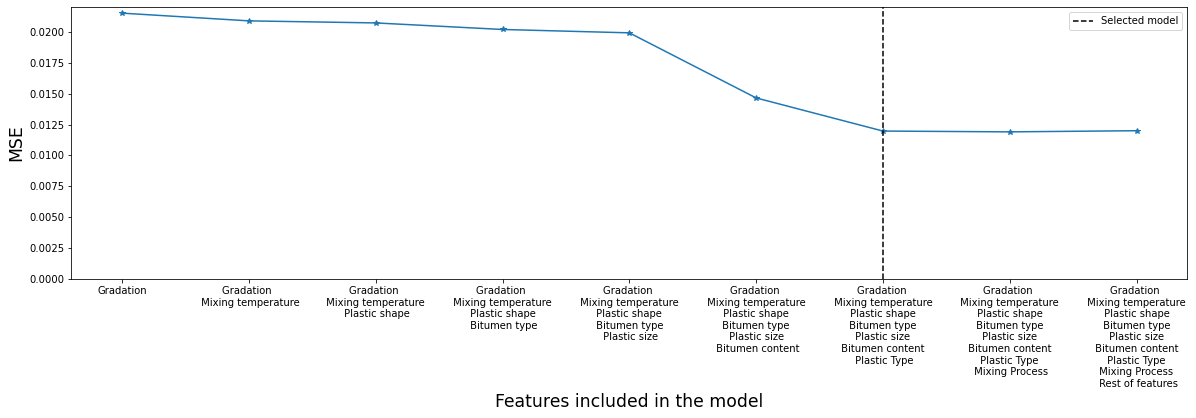

In [188]:
 plt.plot(features_MSE.keys(), features_MSE.values(), marker = '*') 
 plt.ylim(ymin = 0)
 plt.axvline(x='Gradation \n Mixing temperature \n Plastic shape \n Bitumen type \n Plastic size \n Bitumen content \n Plastic Type', ymin=0, ymax=1, color = 'k', ls = '--' , label='Selected model')
 plt.ylabel('MSE', fontsize = 'xx-large')
 plt.xlabel('Features included in the model', fontsize = 'xx-large')
 plt.legend()
 plt.show()

## 6.2 Tunning

In [19]:
X_train =  X_train[['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
                'Mixing Temperature',
                'Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
                'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100',
                'Plastic particle size (mm)',
                'Bitumen content in the sample',
                'New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
                'New Plastic Type_PS', 'New Plastic Type_PU','New Plastic Type_Plastic Mix',
        ]]
X_test = X_test [['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
                'Mixing Temperature',
                'Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
                'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100',
                'Plastic particle size (mm)',
                'Bitumen content in the sample',
                'New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
                'New Plastic Type_PS', 'New Plastic Type_PU','New Plastic Type_Plastic Mix',
        ]]

In [194]:
def tuning_evaluation (parameters, X, y):
    param_grid = parameters
    grid = GridSearchCV(XGBRegressor(random_state = 123), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
    grid.fit(X, y)
    test_MSE = -grid.cv_results_['mean_test_neg_mean_squared_error'][grid.best_index_]
    test_r2 = grid.cv_results_['mean_test_r2'][grid.best_index_]
    best_param = grid.best_params_
    print ('r2 test: ' + str(test_r2))
    print ('MSE test: ' + str(test_MSE))
    print ('Best Parameters ' + str(best_param))

In [196]:
XGBoostModel = XGBRegressor()
scores = cross_val_score(XGBoostModel, X_train, y_train , scoring = 'neg_mean_squared_error', cv = cv)
scores = np.absolute(scores)
print (scores.mean())

0.011970776314863409


In [195]:
param_grid = {
        'eta':[0.1, 0.2, 0.3, 0.4, 0.5]
    }
tuning_evaluation (param_grid, X_train, y_train)

r2 test: 0.6599266572669528
MSE test: 0.01190010633055759
Best Parameters {'eta': 0.2}


In [201]:
param_grid = {
        'eta':[0.2],
        'max_depth':np.arange(3,11,1)
    }
tuning_evaluation (param_grid, X_train, y_train)

r2 test: 0.6599266572669528
MSE test: 0.01190010633055759
Best Parameters {'eta': 0.2, 'max_depth': 6}


In [198]:
param_grid = {
        'eta':[0.2],
        'max_depth':[8],
        'min_child_weight':np.arange(1,11,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

r2 test: 0.6615687315206333
MSE test: 0.011902752150111844
Best Parameters {'eta': 0.3, 'max_depth': 8, 'min_child_weight': 1}


In [199]:
param_grid = {
        'eta':[0.3],
        'max_depth':[8],
        'min_child_weight':[1],
        'max_delta_step': np.arange(0,11,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

r2 test: 0.6616548413930269
MSE test: 0.011898762700936578
Best Parameters {'eta': 0.3, 'max_delta_step': 1, 'max_depth': 8, 'min_child_weight': 1}


In [200]:
param_grid = {
        'eta':[0.3],
        'max_depth':[8],
        'min_child_weight':[1],
        'max_delta_step': [1],
        'gamma' : [0, 0.001, 0.01, 0.1, 1, 10]
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

r2 test: 0.6616548413930269
MSE test: 0.011898762700936578
Best Parameters {'eta': 0.3, 'gamma': 0, 'max_delta_step': 1, 'max_depth': 8, 'min_child_weight': 1}


In [ ]:
param_grid = {
        'eta':[0.3],
        'max_depth':[6],
        'min_child_weight':[1],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : np.arange(0.5, 1.1, 0.1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.3],
        'max_depth':[6],
        'min_child_weight':[1],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[0, 0.5 ,1],
        'colsample_bylevel':[0, 0.5 ,1],
        'colsample_bynode':[0, 0.5 ,1]
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.3],
        'max_depth':[6],
        'min_child_weight':[1],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[1],
        'colsample_bylevel':[1],
        'colsample_bynode':[1],
        'lambda' : np.arange(5,15,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.3],
        'max_depth':[6],
        'min_child_weight':[1],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[1],
        'colsample_bylevel':[1],
        'colsample_bynode':[1],
        'lambda' : [13],
        'alpha' : np.arange(0,11,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.3],
        'max_depth':[6],
        'min_child_weight':[1],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[1],
        'colsample_bylevel':[1],
        'colsample_bynode':[1],
        'lambda' : [13],
        'alpha' : [0],
        'tree_method' : ['exact', 'approx', 'hist', 'gpu_hist']
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [114]:
param_grid = {
        'eta':[0.3],
        'max_depth':[6],
        'min_child_weight':[1],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[1],
        'colsample_bylevel':[1],
        'colsample_bynode':[1],
        'lambda' : [13],
        'alpha' : [0],
        'tree_method' : ['approx'],
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

r2 test: 0.661284133602643
MSE test: 0.011898756650992751
Best Parameters {'alpha': 0, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'eta': 0.3, 'gamma': 0, 'lambda': 13, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 1, 'tree_method': 'approx'}


### 6.3 Final model evaluation on test set

In [116]:
XGModel = XGBRegressor(random_state = 1,
                        eta = 0.3,
                        max_depth = 6,
                        min_child_weight =1,
                        max_delta_step = 0,
                        gamma = 0,
                        subsample = 1,
                        colsample_bytree = 1,
                        colsample_bylevel = 1,
                        colsample_bynode = 1, 
                        reg_lambda = 13,
                        alpha = 0,
                        tree_method = 'approx')
XGModel.fit(X_train, y_train)
predictions_test = XGModel.predict(X_test)
r2_test = r2_score(y_test, predictions_test)
mse_test = mean_squared_error(y_test, predictions_test)
print('The test r2 is: ' + str(r2_test))
print('The test MSE is: ' + str(mse_test))
predictions_train = XGModel.predict(X_train)
r2_train = r2_score(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
print('The test r2 is: ' + str(r2_train))
print('The test MSE is: ' + str(mse_train))

The test r2 is: 0.7829953931309037
The test MSE is: 0.007383127104154649
The test r2 is: 0.9860076785685279
The test MSE is: 0.0005240580387808189


In [20]:
XGModel = XGBRegressor()
XGModel.fit(X_train, y_train)
predictions_test = XGModel.predict(X_test)
r2_test = r2_score(y_test, predictions_test)
mse_test = mean_squared_error(y_test, predictions_test)
print('The test r2 is: ' + str(r2_test))
print('The test MSE is: ' + str(mse_test))
predictions_train = XGModel.predict(X_train)
r2_train = r2_score(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
print('The train r2 is: ' + str(r2_train))
print('The train MSE is: ' + str(mse_train))

The test r2 is: 0.764170495971544
The test MSE is: 0.008023604790114717
The train r2 is: 0.9979744829754155
The train MSE is: 7.58622137591394e-05


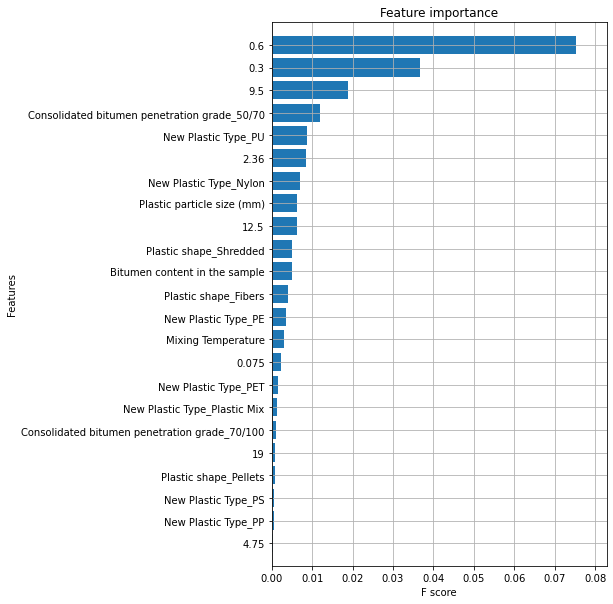

In [204]:
ax = xgb.plot_importance(XGModel, height=0.8, importance_type = 'gain', show_values = False)
fig = ax.figure
fig.set_size_inches(6,10)